# Explainable AI

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../fmriDEEP'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np
from _core.networks.ConvNets import Simple2dCnnClassifier
from _utils.tools import compute_accuracy
from torch.utils.data import DataLoader
from zennit import composites
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# this variable contains information whether a GPU can be used for training. If not, we automatically use the CPU.
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# set the random seed for reproducibility
def set_random_seed(seed):
    import random 
    
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    g = torch.Generator() # can be used in pytorch dataloaders for reproducible sample selection when shuffle=True
    g.manual_seed(seed)
    
    return g

g = set_random_seed(42)

In [12]:
def train_network(model, n_epochs, lr=.01, device=torch.device("cpu"), save_name=None):
    #set some variables here, such that we can create pretty plots
    train_loss = np.zeros(n_epochs)
    test_loss = np.zeros_like(train_loss)
    train_acc = np.zeros_like(train_loss)
    test_acc = np.zeros_like(train_loss)

    # loop for the above set number of epochs
    for epoch in range(0, n_epochs):

        # THIS IS WHERE THE MAGIC HAPPENS
        # calling the model.fit() function will execute the 'standard_train' function as defined above.
        train_loss[epoch], train_stats = model.fit(dl_train, lr=.01, device=device)
        train_acc[epoch] = compute_accuracy(train_stats[:, -1], train_stats[:, -2])

        # for validating or testing set the network into evaluation mode such that layers like dropout are not active
        with torch.no_grad():
            test_loss[epoch], test_stats = model.fit(dl_test, device=device)
            test_acc[epoch] = compute_accuracy(test_stats[:, -1], test_stats[:, -2], train=False)

        print('epoch=%03d, train_loss=%1.3f, train_acc=%1.3f, test_loss=%1.3f, test_acc=%1.3f' % 
             (epoch, train_loss[epoch], train_acc[epoch], test_loss[epoch], test_acc[epoch]))

    model.save(save_name, save_full=True)

In [4]:
training_data = FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
dl_train = DataLoader(training_data, batch_size=256, shuffle=True)
test_data = FashionMNIST(root="data",train=False,download=True,transform=ToTensor())
dl_test = DataLoader(test_data, batch_size=256, shuffle=False)

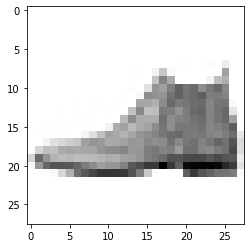

In [5]:
plt.imshow(test_data.data[0, :, :], cmap='Greys')

In [6]:
model = Simple2dCnnClassifier((28, 28), 10)

In [7]:
train_network(model, 10)

epoch=000, train_loss=0.846, train_acc=0.674, test_loss=0.490, test_acc=0.824
epoch=001, train_loss=0.516, train_acc=0.814, test_loss=0.403, test_acc=0.846
epoch=002, train_loss=0.477, train_acc=0.829, test_loss=0.399, test_acc=0.854
epoch=003, train_loss=0.458, train_acc=0.836, test_loss=0.374, test_acc=0.860
epoch=004, train_loss=0.454, train_acc=0.838, test_loss=0.379, test_acc=0.864
epoch=005, train_loss=0.447, train_acc=0.841, test_loss=0.377, test_acc=0.861
epoch=006, train_loss=0.441, train_acc=0.843, test_loss=0.384, test_acc=0.854
epoch=007, train_loss=0.449, train_acc=0.841, test_loss=0.369, test_acc=0.863
epoch=008, train_loss=0.449, train_acc=0.840, test_loss=0.375, test_acc=0.859
epoch=009, train_loss=0.453, train_acc=0.841, test_loss=0.357, test_acc=0.864
Saving entire model my_cnn_fashionmnist/model.pth


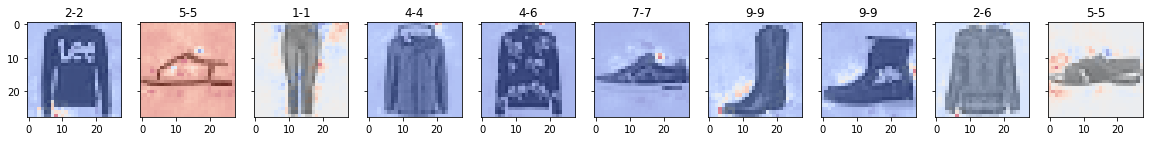

In [18]:
import copy
from zennit.attribution import Gradient

shape = (1, 1, 28, 28)

composite_kwargs = {
    'low': 0 * torch.ones(*shape, device=torch.device("cpu")),  # the lowest and ...
    'high': 1 * torch.ones(*shape, device=torch.device("cpu")),  # the highest pixel value for ZBox
}

test = composites.COMPOSITES['epsilon_gamma_box'](**composite_kwargs)


for param in model.parameters():
    param.requires_grad = False


pick_img = 1
    
fig, axes = plt.subplots(1, 10, figsize=(20, 8), sharex=True, sharey=True)
#with Gradient(model=model, composite=test) as modified_model:
with test.context(model) as modified_model:
    ctr = 0
    for i, (data, target) in enumerate(dl_test):
        data_with_grad = data.clone()
        data_with_grad.requires_grad_()
        
        output_relevance = torch.eye(10, device=torch.device("cpu"))[target]

        #out, attribution = modified_model(data_with_grad)
        out = modified_model(data_with_grad)
        predicted = np.argmax(out.detach().numpy(), axis=1)
        torch.autograd.backward(out, output_relevance)
        axes[ctr].imshow(data[pick_img, :, :].squeeze().squeeze().cpu().numpy(), cmap='Greys')
        #axes[ctr].imshow(attribution[pick_img,:,:].squeeze().squeeze().cpu().numpy(), cmap='coolwarm', alpha=.5)
        axes[ctr].imshow(data_with_grad.grad[pick_img,:,:].squeeze().squeeze().cpu().numpy(), cmap='coolwarm', alpha=.5)
        axes[ctr].set_title(f'{predicted[pick_img]}-{target[pick_img]}')
        
        
        ctr += 1
        if ctr > 9:
            break

## Explain brain data

In [10]:
import nibabel as nib
from _utils.train_fns import standard_train
from _core.networks.ConvNets import BrainStateClassifier3d
from _core.datasets.NiftiDataset import NiftiDataset
import _utils.tools as utils

In [25]:
labels = ['handleft', 'handright', 'footleft', 'footright', 'tongue']
dl_train = DataLoader(NiftiDataset(
    'data/brain_data/train', labels, 2, DEVICE, transform=utils.ToTensor()), 
    batch_size=4, shuffle=True, generator=g
)
dl_test = DataLoader(NiftiDataset(
    'data/brain_data/test', labels, 2, DEVICE, transform=utils.ToTensor()), 
    batch_size=4, shuffle=True, generator=g
)